# Face Recognition Challege

- Task: Given a data set consisting of facial images, retrieve all images which are similar to the give test image

### Summary of the implementation

- Dataset Used: sklearn lfw_people dataset
- Primary Feature Extraction Algorithm: Histogram of Oriented Gradients (HoG)
- Prediction Model: Support Vector Machine (SVM)
- Prediction Accuracy: 91.69%

The above model is fairly accurate in "recognising" facial images and behaves good enough the given dataset. Although, it is not as accurate as a Convolutional Neural Network or any other Deep Learning Model.



In [ ]:
%matplotlib inline
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
from skimage.feature import hog

Text(0.5, 1.0, 'HoG Feature Visualization')

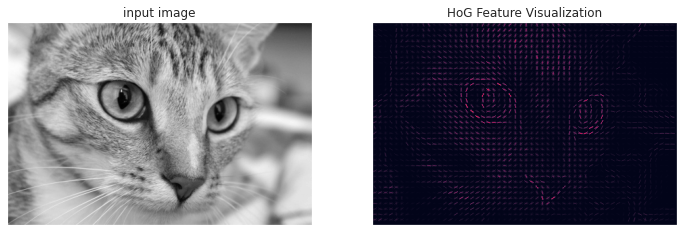

In [ ]:
# The following code block implements and tests the inbuilt HoG feature on some test image
from skimage import data, color, feature, exposure
import skimage.data

image = color.rgb2gray(data.chelsea())
# feature.hog gives us the HoG of the image based on the passed parameters
(H, hogImage) = feature.hog(image, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0,255))
hogImage = hogImage.astype("uint8")

fig, ax = plt.subplots(1, 2, figsize=(12, 6), subplot_kw=dict(xticks=[], yticks=[]))

ax[0].imshow(image, cmap='gray')
ax[0].set_title('input image')

ax[1].imshow(hogImage)
ax[1].set_title('HoG Feature Visualization')

## Dataset Fetching and Pre-processing

### Dataset Details

`fetch_lfw_people` return a Dictionary like object with the following attributes:
-  data: numpy array 
- images: numpy array (facial image)
- target: Labels associated with each image

In [ ]:
# importing dataset from sklearn
from sklearn.datasets import fetch_lfw_people

In [ ]:
class lfwDataset():
    # constructor to fetch and initialise the data   
    def __init__(self, min_faces_per_person):
        self.faces = fetch_lfw_people(min_faces_per_person=min_faces_per_person)
    # plot sample data
    def plot_sample(self):
        fig, ax = plt.subplots(2,3)
        for i, axi in enumerate(ax.flat):
            axi.imshow(self.faces.images[i], cmap='bone')
            axi.set(xticks=[], yticks=[],
            xlabel=self.faces.target_names[self.faces.target[i]])
            # print(self.faces.target_names[self.faces.target[i]])    
    # get feature labels from the dataset
    def get_feature_labels(self):
        return self.faces.images, self.faces.target, self.faces.target_names #self.faces.images

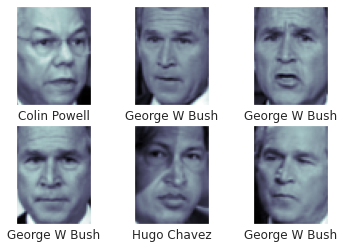

In [ ]:
# plotting the test data
lfw_ds = lfwDataset(60)
lfw_ds.plot_sample()

In [ ]:
# fetching the desired features from the dataset i.e images, labels and target_names for further processing
image, labels, target_names = lfw_ds.get_feature_labels()
_, h,w = image.shape

# Debug statements
print(target_names.shape)
print(labels.shape)
print(image.shape)
print(h)
print(w)
# print(images.shape)

(8,)
(1348,)
(1348, 62, 47)
62
47


(1011, 62, 47)
(337, 62, 47)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


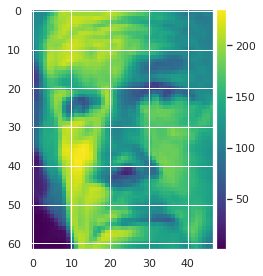

In [ ]:
# splitting the given dataset into test and train data
# X_train and X_test correspond to the images, whereas y_train and y_test correspond to the labels for those images
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image, labels, random_state=42)

# debug statements
print(X_train.shape)
print(X_test.shape)
imshow(X_train[0])

## HOG Implementation

In [ ]:
from skimage.transform import resize  # to resize images into 64*64

# HoG is applied to each X_train and X_test datasets and stored into their corresponding lists
# HoG is an important feature detector that decomposes an image into small squared cells, computes an histogram of oriented
# gradients in each cell, normalises the results using a block-wise pattern and returns a descriptor for each cell.

hogImageListTrain = []
hogImageFeaturesTrain = []
for i in range(len(X_train)):
  resized_image = resize(X_train[i], (64,64))
  (H, hogImage) = hog(resized_image, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)
  # hogImage = exposure.rescale_intensity(hogImage, out_range=(0,255))
  # hogImage = hogImage.astype("uint8")
  hogImageListTrain.append(hogImage)
  hogImageFeaturesTrain.append(H)

hogImageListTest = []
hogImageFeaturesTest = []
for i in range(len(X_test)):
  resized_image = resize(X_test[i], (64,64))
  (H, hogImage) = hog(resized_image, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1", visualize=True)
  # hogImage = exposure.rescale_intensity(hogImage, out_range=(0,255))
  # hogImage = hogImage.astype("uint8")
  hogImageListTest.append(hogImage)
  hogImageFeaturesTest.append(H)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


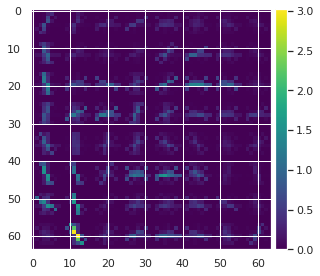

In [ ]:
# debug
imshow(hogImageListTrain[0])
# print(hogImageFeaturesTrain.shape)
hog = np.array(hogImageFeaturesTrain)

## Prediction Model

In [ ]:
# converting the feature labels to np array for prediction model
hog_features_train = np.array(hogImageFeaturesTrain)
hog_features_test = np.array(hogImageFeaturesTest)
# data_frame = np.hstack(hogImageListTrain, hogImageFeaturesTrain)

In [ ]:
# Using SVM to build the model.
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

param_grid = {
    'C': [1e3, 5e3, 1e4, 5e4, 1e5],
    'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],
}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(hog_features_train, y_train)
print(clf.best_estimator_)

SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
# predicting the results
y_pred = clf.predict(hog_features_test)

In [ ]:
# Report
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.75      0.80      0.77        15
     Colin Powell       0.94      0.97      0.96        68
  Donald Rumsfeld       0.90      0.84      0.87        31
    George W Bush       0.94      0.95      0.95       126
Gerhard Schroeder       0.78      0.91      0.84        23
      Hugo Chavez       0.94      0.80      0.86        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.95      0.86      0.90        42

         accuracy                           0.92       337
        macro avg       0.89      0.89      0.89       337
     weighted avg       0.92      0.92      0.92       337



In [ ]:
# helper functions to print the output (ref: https://towardsdatascience.com/building-a-facial-recognition-model-using-pca-svm-algorithms-c81d870add16)
def title(y_pred, y_test, target_names, i):
  pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
  true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
  return 'predicted: %s\ntrue:  %s' % (pred_name, true_name)

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
  plt.figure(figsize=(1.8*n_col, 2.4*n_row))
  plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
  for i in range(n_row * n_col):
    plt.subplot(n_row, n_col, i + 1)
    plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(titles[i], size=12)
    plt.xticks(())
    plt.yticks(())

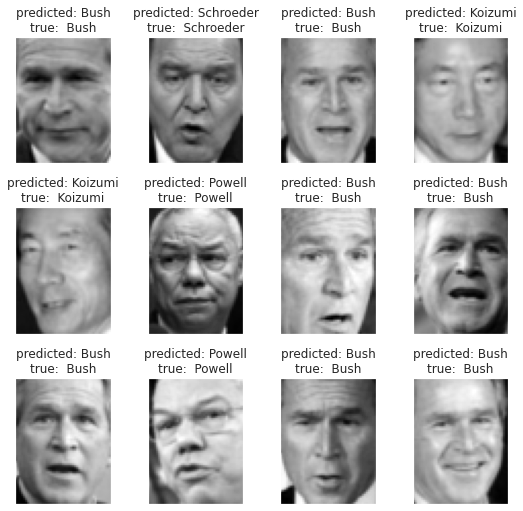

In [ ]:
# printing prediction results in a more 'intuitive' manner
prediction_titles = [title(y_pred, y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

In [ ]:
# Finally, printing the accurary score
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_pred)
print(score*100)

91.69139465875371
